# Long Short-Term Memory (LSTM)
LSTM은 순환 신경망(RNN)의 변형 구조로, 시퀀스 데이터의 장기 의존성 학습을 위해 설계됐다. 1997년 Hochreiter & Schmidhuber가 제안했으며, 기존 RNN의 기울기 소실 문제를 해결하기 위해 셀 상태(Cell State)와 세 가지 게이트(입력, 망각, 출력)를 도입했다. 특히 금융, 자연어 처리, 음성 인식 등 시계열 데이터 분석에서 널리 사용된다.


### 응용 분야
- 긴 시퀀스의 자연어 처리
- 음성 인식 및 합성
- 시계열 예측
- 기계 번역
- 감성 분석

### 장점
- 장기 의존성 문제 해결
- 기울기 소실/폭발 문제 완화
- 선택적 정보 저장 및 제거 가능

### 단점
- RNN보다 복잡한 구조로 인한 계산 비용 증가
- 많은 메모리 요구
- 하이퍼파라미터 튜닝의 어려움

# (시퀀스) 데이터 생성


```
## 1. 먼저 데이터가 정규화됩니다 (0~1 사이 값으로)

정규화된_데이터 = {
    'Open':   [0.1, 0.2, 0.3, 0.4, 0.5],
    'High':   [0.15, 0.25, 0.35, 0.45, 0.55],
    'Low':    [0.05, 0.15, 0.25, 0.35, 0.45],
    'Close':  [0.1, 0.2, 0.3, 0.4, 0.5],
    'Volume': [0.0, 0.4, 0.2, 0.3, 0.9],
    'MACD':   [0.0, 0.1, 0.2, 0.3, 0.5],
    'Signal': [0.0, 0.05, 0.1, 0.2, 0.3]
}

## 2. 시퀀스 생성 (seq_length=3)

첫번째_시퀀스 = {
    # 입력(X[0]): 1일, 2일, 3일 데이터
    "입력": [
        # 2024-01-01 데이터
        [0.1, 0.15, 0.05, 0.1, 0.0, 0.0, 0.0],
        # 2024-01-02 데이터
        [0.2, 0.25, 0.15, 0.2, 0.4, 0.1, 0.05],
        # 2024-01-03 데이터
        [0.3, 0.35, 0.25, 0.3, 0.2, 0.2, 0.1]
    ],
    # 타겟(y[0]): 4일의 종가
    "타겟": 0.4  # 2024-01-04의 Close 값
}

두번째_시퀀스 = {
    # 입력(X[1]): 2일, 3일, 4일 데이터
    "입력": [
        # 2024-01-02 데이터
        [0.2, 0.25, 0.15, 0.2, 0.4, 0.1, 0.05],
        # 2024-01-03 데이터
        [0.3, 0.35, 0.25, 0.3, 0.2, 0.2, 0.1],
        # 2024-01-04 데이터
        [0.4, 0.45, 0.35, 0.4, 0.3, 0.3, 0.2]
    ],
    # 타겟(y[1]): 5일의 종가
    "타겟": 0.5  # 2024-01-05의 Close 값
}
```


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 1. 가상의 주식 데이터 생성
def generate_stock_data(days=100, volatility=0.02):
    # 기준 가격
    base_price = 10000
    
    # 시간 생성
    dates = pd.date_range(start='2024-01-01', periods=days)
    
    # 기본 추세 (상승추세)
    trend = np.linspace(0, 0.5, days)
    
    # 가격 변동 시뮬레이션
    prices = base_price * (1 + trend + np.random.normal(0, volatility, days).cumsum())
    
    # 일중 변동 생성
    high_prices = prices * (1 + np.random.uniform(0, 0.02, days))
    low_prices = prices * (1 - np.random.uniform(0, 0.02, days))
    open_prices = prices * (1 + np.random.uniform(-0.01, 0.01, days))
    
    # 거래량 생성 (가격 변동과 연관)
    volume = np.exp(np.random.normal(10, 0.5, days)) * (1 + np.abs(np.diff(prices, prepend=prices[0])))
    
    # 데이터프레임 생성
    df = pd.DataFrame({
        'Date': dates,
        'Open': open_prices.round(2),
        'High': high_prices.round(2),
        'Low': low_prices.round(2),
        'Close': prices.round(2),
        'Volume': volume.round(0)
    })
    
    return df

# 2. 기술적 지표 추가
def add_technical_indicators(df):
    # 이동평균
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    
    # RSI (Relative Strength Index)
    delta = df['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence Divergence)
    exp1 = df['Close'].ewm(span=12, adjust=False).mean()
    exp2 = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    return df

In [23]:
# 3. 데이터 생성 및 전처리
stock_data = generate_stock_data(days=1000)
stock_data = add_technical_indicators(stock_data)

stock_data.head()
print(stock_data.shape)


(1000, 11)


In [24]:
# NaN 값 처리
stock_data = stock_data.fillna(method='ffill')  # 앞의 값으로 채우기
stock_data.head()


C:\Users\dongi\AppData\Local\Temp\ipykernel_39100\1343570327.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data = stock_data.fillna(method='ffill')  # 앞의 값으로 채우기


,Date,Open,High,Low,Close,Volume,MA5,MA20,RSI,MACD,Signal
0,2024-01-01,10072.98,10338.33,10133.84,10137.18,14047.0,NaN,NaN,NaN,0.000000,0.000000
1,2024-01-02,9763.40,9912.88,9674.05,9817.08,10201044.0,NaN,NaN,NaN,-25.535043,-5.107009
2,2024-01-03,9960.43,9944.23,9831.43,9898.49,913090.0,NaN,NaN,NaN,-38.755888,-11.836784
3,2024-01-04,9557.86,9571.52,9382.34,9543.10,9664574.0,NaN,NaN,NaN,-77.022636,-24.873955
4,2024-01-05,9665.50,9810.82,9636.42,9692.87,2543057.0,9817.744,NaN,NaN,-94.178492,-38.734862


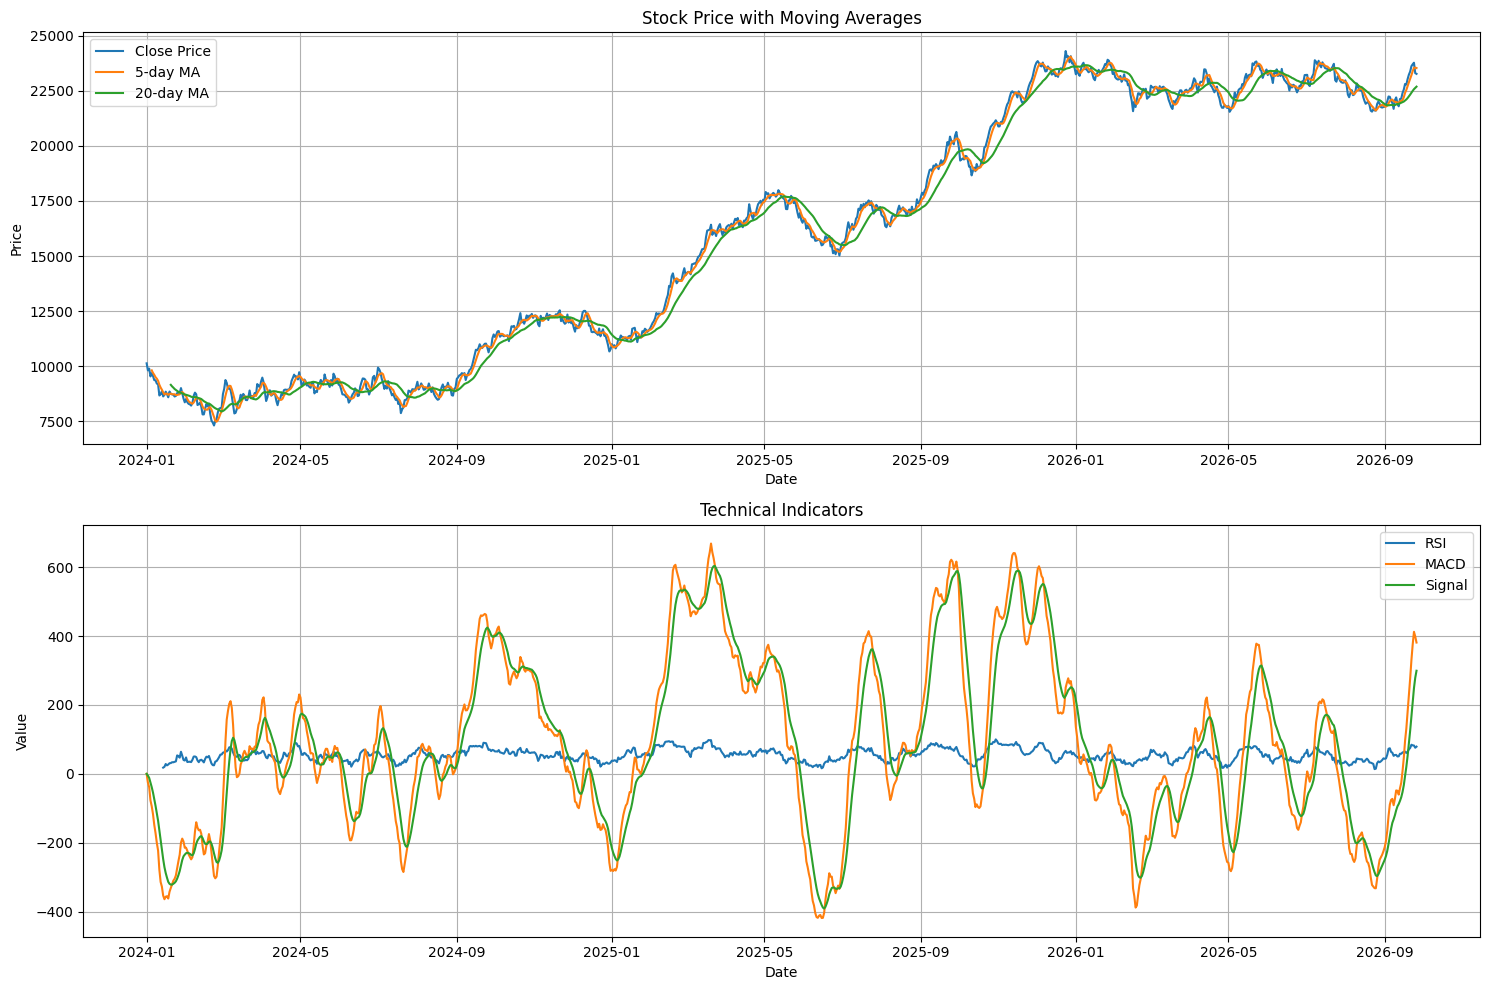


=== 기본 통계량 ===
           Open      High       Low     Close       Volume
count   1000.00   1000.00   1000.00   1000.00      1000.00
mean   16038.28  16200.91  15880.03  16038.54   4136303.88
std     5688.18   5753.30   5631.28   5687.71   4271913.65
min     7263.04   7447.60   7284.35   7317.75     14047.00
25%     9781.54   9936.39   9711.90   9828.63   1376771.75
50%    16386.50  16535.71  16276.19  16396.67   2855965.00
75%    22308.83  22475.33  22011.93  22300.20   5584581.50
max    24461.56  24677.57  24277.59  24298.02  42287276.00


In [25]:
# 4. 데이터 시각화
plt.figure(figsize=(15, 10))

# 가격 차트
plt.subplot(2, 1, 1)
plt.plot(stock_data['Date'], stock_data['Close'], label='Close Price')
plt.plot(stock_data['Date'], stock_data['MA5'], label='5-day MA')
plt.plot(stock_data['Date'], stock_data['MA20'], label='20-day MA')
plt.title('Stock Price with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# 기술적 지표
plt.subplot(2, 1, 2)
plt.plot(stock_data['Date'], stock_data['RSI'], label='RSI')
plt.plot(stock_data['Date'], stock_data['MACD'], label='MACD')
plt.plot(stock_data['Date'], stock_data['Signal'], label='Signal')
plt.title('Technical Indicators')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 5. 기본 통계량
print("\n=== 기본 통계량 ===")
print(stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].describe().round(2))

In [41]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# 1. 사용할 특성과 타겟 지정
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
target_col = 'Close'
seq_length = 10  # 10일간의 데이터로 다음 날을 예측

# 2. 각 컬럼별로 개별적으로 스케일링
scalers = {}
scaled_data = {}

# 각 특성별로 스케일링
for column in feature_cols:
    scalers[column] = StandardScaler()
    scaled_data[column] = scalers[column].fit_transform(stock_data[column].values.reshape(-1, 1)).flatten()

# DataFrame 생성
scaled_df = pd.DataFrame(scaled_data, index=stock_data.index)

# 3. 시퀀스 데이터 생성
X = []  # 입력 데이터 (10일치 데이터들)
y = []  # 타겟 데이터 (11일째 종가)

for i in range(len(scaled_df) - seq_length):
    X.append(scaled_df.iloc[i:(i + seq_length)].values)  # scaled_df 사용
    y.append(scaled_df.iloc[i + seq_length]['Close'])    # scaled_df 사용

X = np.array(X)
y = np.array(y)

# 4. 학습/테스트 데이터 분할 (80:20)
train_size = int(len(X) * 0.8)
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print("\n=== 데이터셋 형태 ===")
print(f"X_train shape: {X_train.shape}")  # (샘플 수, 시퀀스 길이, 특성 수)
print(f"y_train shape: {y_train.shape}")  # (샘플 수,)


=== 데이터셋 형태 ===
X_train shape: (792, 10, 5)
y_train shape: (792,)


# 모델 학습

## 모델 구조
LSTM은 RNN의 장기 의존성 문제를 해결하기 위해 설계된 특별한 구조입니다.

- **입력 시퀀스**: 시간에 따른 순차 데이터
  - 예: 문장의 단어들, 시계열 데이터

- **게이트 메커니즘**:
  - **망각 게이트** (forget gate): 이전 정보 중 잊을 것을 결정
      - 0(완전히 버림) ~ 1(완전히 유지) 사이 값 출력
      - $f_t = σ(W_f[h_(t-1), x_t] + b_f)$
  - **입력 게이트** (input gate): 새로운 정보의 저장을 결정
      - $i_t = σ(W_i[h_(t-1), x_t] + b_i)$
  - **출력 게이트** (output gate): 현재 셀의 출력을 결정
      - $o_t = σ(W_o[h_(t-1), x_t] + b_o)$
  - **셀 상태** (cell state): 장기 메모리 역할
      - 정보의 장기 저장소 역할
      - 선형적인 정보 흐름으로 기울기 소실 문제 완화
      - 수식: $C_t = f_t * C_(t-1) + i_t * tanh(W_c[h_(t-1), x_t] + b_c)$
  - **은닉 상태** (Hidden State): 출력 게이트와 셀 상태로부터 계산
      - 수식: $h_t = o_t * tanh(C_t)$

- **가중치**:
  - `W_f`: 망각 게이트 가중치
  - `W_i`: 입력 게이트 가중치
  - `W_c`: 셀 상태 가중치
  - `W_o`: 출력 게이트 가중치

- **활성화 함수**:
  - **sigmoid**: 게이트 제어 (0~1 사이 값)
  - **tanh**: 셀 상태와 은닉 상태 계산

> 참고:
> - σ는 시그모이드 함수 (0~1 사이 값 출력)
> - tanh는 하이퍼볼릭 탄젠트 함수 (-1~1 사이 값 출력)
> - *는 요소별 곱셈(element-wise multiplication)을 의미

In [58]:
# 1. 하이퍼파라미터 설정
input_size = 5      # 입력 크기 (주가 관련 5개 특성)
hidden_size = 32    # 은닉층 크기
output_size = 1     # 출력 크기 (예측 종가)

# 2. 가중치와 편향 초기화
def init_weights():
    # 입력 게이트: "새로운 정보를 얼마나 받아들일까?"
    Wi = np.random.randn(hidden_size, input_size) * 0.01
    Ui = np.random.randn(hidden_size, hidden_size) * 0.01
    bi = np.zeros((hidden_size, 1))
    
    # 망각 게이트: "이전 정보를 얼마나 유지할까?"
    Wf = np.random.randn(hidden_size, input_size) * 0.01
    Uf = np.random.randn(hidden_size, hidden_size) * 0.01
    bf = np.ones((hidden_size, 1))  # 1로 초기화 (정보를 잘 기억하도록)
    
    # 출력 게이트: "현재 정보를 얼마나 내보낼까?"
    Wo = np.random.randn(hidden_size, input_size) * 0.01
    Uo = np.random.randn(hidden_size, hidden_size) * 0.01
    bo = np.zeros((hidden_size, 1))
    
    # 셀 상태 후보: "어떤 새로운 정보를 저장할까?"
    Wc = np.random.randn(hidden_size, input_size) * 0.01
    Uc = np.random.randn(hidden_size, hidden_size) * 0.01
    bc = np.zeros((hidden_size, 1))
    
    # 출력층
    Why = np.random.randn(output_size, hidden_size) * 0.01
    by = np.zeros((output_size, 1))
    
    return Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc, Why, by

# 3. 시그모이드와 tanh 함수
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 4. LSTM 순전파
def lstm_forward(x, h_prev, c_prev, weights):
    Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc, Why, by = weights
    
    # 게이트 계산
    f = sigmoid(np.dot(Wf, x) + np.dot(Uf, h_prev) + bf)  # 망각 게이트
    i = sigmoid(np.dot(Wi, x) + np.dot(Ui, h_prev) + bi)  # 입력 게이트
    o = sigmoid(np.dot(Wo, x) + np.dot(Uo, h_prev) + bo)  # 출력 게이트
    
    # 셀 상태 후보
    c_tilde = np.tanh(np.dot(Wc, x) + np.dot(Uc, h_prev) + bc)
    
    # 셀 상태 업데이트
    c = f * c_prev + i * c_tilde
    
    # 은닉 상태 업데이트
    h = o * np.tanh(c)
    
    # 출력 계산
    y = np.dot(Why, h) + by
    
    # 중간 값들 캐시 (역전파용)
    cache = (x, h_prev, c_prev, f, i, o, c_tilde, c, h)
    
    return y, h, c, cache

def lstm_backward(dy, cache, weights):
    x, h_prev, c_prev, f, i, o, c_tilde, c, h = cache
    Wi, Ui, bi, Wf, Uf, bf, Wo, Uo, bo, Wc, Uc, bc, Why, by = weights
    
    # 출력층 그래디언트
    dWhy = np.dot(dy, h.T)
    dby = dy
    dh = np.dot(Why.T, dy)
    
    # LSTM 그래디언트
    do = dh * np.tanh(c)
    dc = dh * o * (1 - np.tanh(c)**2)
    
    # 게이트 그래디언트
    di = dc * c_tilde
    df = dc * c_prev
    dc_tilde = dc * i
    
    # 시그모이드와 tanh 미분
    do = do * o * (1 - o)
    di = di * i * (1 - i)
    df = df * f * (1 - f)
    dc_tilde = dc_tilde * (1 - c_tilde**2)
    
    # 가중치 그래디언트
    dWo = np.dot(do, x.T)
    dUo = np.dot(do, h_prev.T)
    dbo = do
    
    dWi = np.dot(di, x.T)
    dUi = np.dot(di, h_prev.T)
    dbi = di
    
    dWf = np.dot(df, x.T)
    dUf = np.dot(df, h_prev.T)
    dbf = df
    
    dWc = np.dot(dc_tilde, x.T)
    dUc = np.dot(dc_tilde, h_prev.T)
    dbc = dc_tilde
    
    return dWi, dUi, dbi, dWf, dUf, dbf, dWo, dUo, dbo, dWc, dUc, dbc, dWhy, dby

In [59]:
# 5. 첫 번째 시퀀스에 대해 실행
weights = init_weights()
x_sample = X_train[0]  # 첫 번째 시퀀스
h = np.zeros((hidden_size, 1))  # 은닉 상태 초기화
c = np.zeros((hidden_size, 1))  # 셀 상태 초기화

print("입력 시퀀스 형태:", x_sample.shape)
print("은닉 상태 초기 형태:", h.shape)

# 시퀀스의 각 시점에 대해 순차적으로 처리
caches = []
for t in range(len(x_sample)):
    xt = x_sample[t].reshape(-1, 1)
    y, h, c, cache = lstm_forward(xt, h, c, weights)
    caches.append(cache)
    
    if t < 3:  # 처음 3개 시점만 출력
        print(f"\n시점 {t+1}:")
        print(f"입력값: {xt.flatten()[:3]}")  # 처음 3개 특성만 출력
        print(f"은닉 상태 일부: {h[:3].flatten()}")
        print(f"셀 상태 일부: {c[:3].flatten()}")

print("\n최종 결과:")
print(f"예측값: {y.flatten()[0]:.4f}")
print(f"실제값: {y_train[0]:.4f}")

# 손실 계산 (MSE)
loss = (y - y_train[0])**2
print(f"손실값: {loss.flatten()[0]:.4f}")

입력 시퀀스 형태: (10, 5)
은닉 상태 초기 형태: (32, 1)

시점 1:
입력값: [-1.0492437  -1.01950414 -1.020917  ]
은닉 상태 일부: [ 0.00506169 -0.00677781 -0.00022101]
셀 상태 일부: [ 0.01011673 -0.01324759 -0.00043689]

시점 2:
입력값: [-1.1036961  -1.09349    -1.10260717]
은닉 상태 일부: [ 0.01622612 -0.01583474 -0.00401944]
셀 상태 일부: [ 0.03261893 -0.03115348 -0.00778899]

시점 3:
입력값: [-1.06904025 -1.08803822 -1.07464572]
은닉 상태 일부: [ 0.01788047 -0.0188932  -0.00313279]
셀 상태 일부: [ 0.03578581 -0.03692091 -0.00617851]

최종 결과:
예측값: 0.0030
실제값: -1.2947
손실값: 1.6840


In [60]:
def train_lstm(X_train, y_train, epochs=100):
    weights = init_weights()
    learning_rate = 0.01
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        
        for i in range(len(X_train)):
            h = np.zeros((hidden_size, 1))
            c = np.zeros((hidden_size, 1))
            x_seq = X_train[i]
            target = y_train[i]
            
            # 순전파
            caches = []
            for t in range(len(x_seq)):
                xt = x_seq[t].reshape(-1, 1)
                y, h, c, cache = lstm_forward(xt, h, c, weights)
                caches.append(cache)
            
            # 손실 계산
            loss = (y - target)**2
            epoch_loss += loss[0, 0]
            
            # 역전파
            dy = 2 * (y - target)
            gradients = lstm_backward(dy, caches[-1], weights)
            
            # 가중치 업데이트
            for w, grad in zip(weights, gradients):
                w -= learning_rate * grad
        
        avg_loss = epoch_loss / len(X_train)
        losses.append(avg_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
            
    return weights, losses

Epoch 1/100, Loss: 0.0997
Epoch 11/100, Loss: 0.0028
Epoch 21/100, Loss: 0.0028
Epoch 31/100, Loss: 0.0028
Epoch 41/100, Loss: 0.0028
Epoch 51/100, Loss: 0.0027
Epoch 61/100, Loss: 0.0027
Epoch 71/100, Loss: 0.0026
Epoch 81/100, Loss: 0.0026
Epoch 91/100, Loss: 0.0025


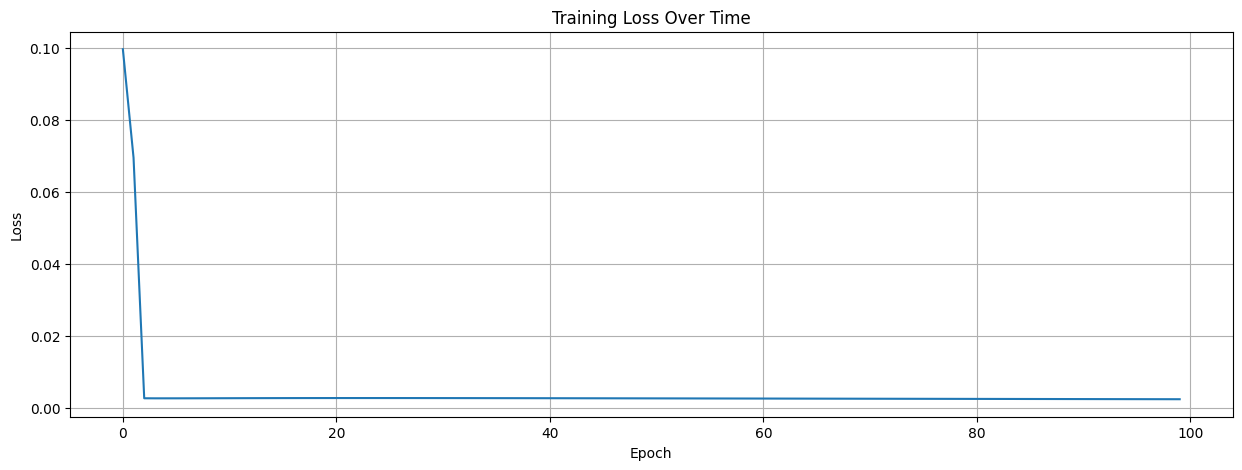

In [61]:
# 7. 실행
# 학습 실행
weights, losses = train_lstm(X_train, y_train, epochs=100)

# 8. 결과 시각화
plt.figure(figsize=(15, 5))
plt.plot(losses)
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

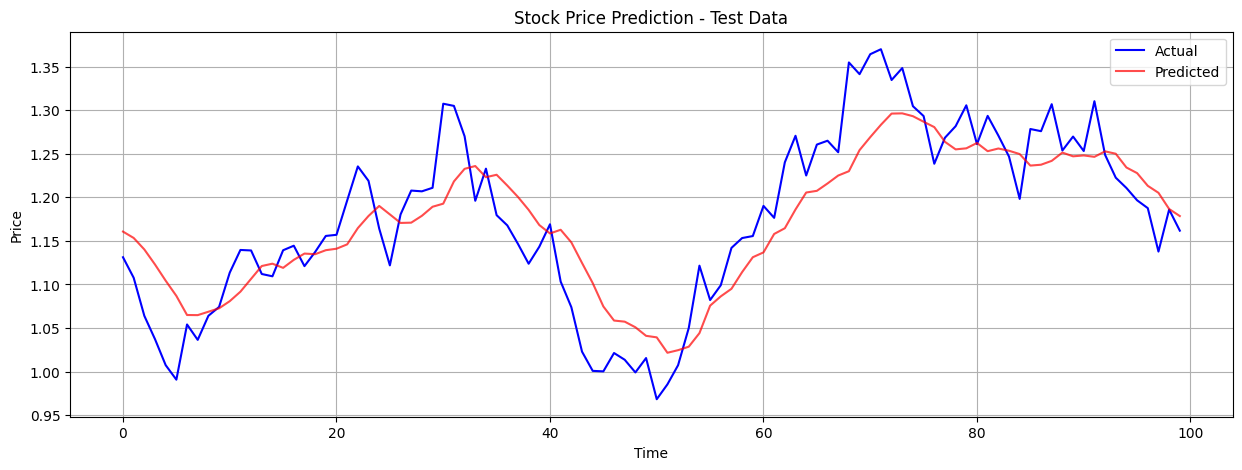

Mean Squared Error: 0.0026


In [62]:
# 9. 테스트 데이터로 예측
def predict(X_test, weights):
    predictions = []
    for i in range(len(X_test)):
        h = np.zeros((hidden_size, 1))
        c = np.zeros((hidden_size, 1))
        x_seq = X_test[i]
        
        # 순전파로 예측
        for t in range(len(x_seq)):
            xt = x_seq[t].reshape(-1, 1)
            y, h, c, _ = lstm_forward(xt, h, c, weights)
        predictions.append(y[0, 0])
    
    return np.array(predictions)

# 예측 실행
y_pred = predict(X_test, weights)

# 10. 예측 결과 시각화
plt.figure(figsize=(15, 5))
plt.plot(y_test[:100], label='Actual', color='blue')
plt.plot(y_pred[:100], label='Predicted', color='red', alpha=0.7)
plt.title('Stock Price Prediction - Test Data')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 11. 성능 평가
mse = np.mean((y_test - y_pred)**2)
print(f'Mean Squared Error: {mse:.4f}')

# 모델 학습 (Keras)

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. LSTM 모델 구축
model = Sequential([
    # LSTM 층 (입력층)
    LSTM(units=50, return_sequences=True, 
         input_shape=(seq_length, len(feature_cols))),
    Dropout(0.2),
    
    # LSTM 층 (중간층)
    LSTM(units=30, return_sequences=False),
    Dropout(0.2),
    
    # 출력층
    Dense(units=1)  # 다음 날의 종가 예측
])

# 2. 모델 컴파일
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error'
)

# 3. 모델 구조 확인
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 10, 50)            11200     
                                                                 
 dropout_10 (Dropout)        (None, 10, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 30)                9720      
                                                                 
 dropout_11 (Dropout)        (None, 30)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 20,951
Trainable params: 20,951
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
20/20 [==============================] - 2s 23ms/step - loss: 0.0713 - val_loss: 0.1473
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0265 - val_loss: 0.0785
Epoch 3/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0220 - val_loss: 0.0972
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0193 - val_loss: 0.1204
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0174 - val_loss: 0.0993
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.1073
Epoch 7/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0166 - val_loss: 0.1119
Epoch 8/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0181 - val_loss: 0.0836
Epoch 9/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0153 - val_loss: 0.0845
Epoch 10/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 0.0836
Epoch 11/50
20/20 

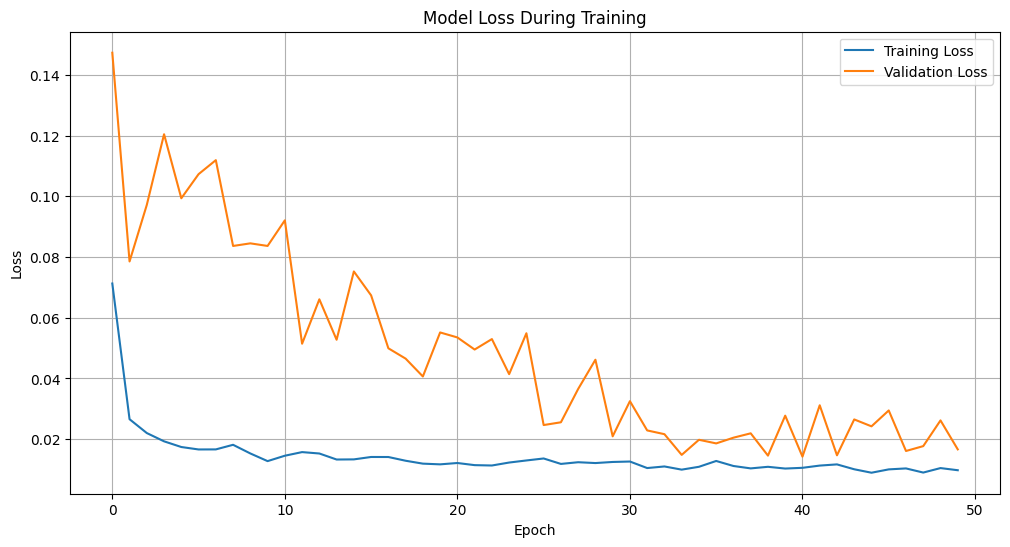

In [43]:
# 4. 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# 5. 학습 과정 시각화
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

7/7 [==============================] - 0s 3ms/step


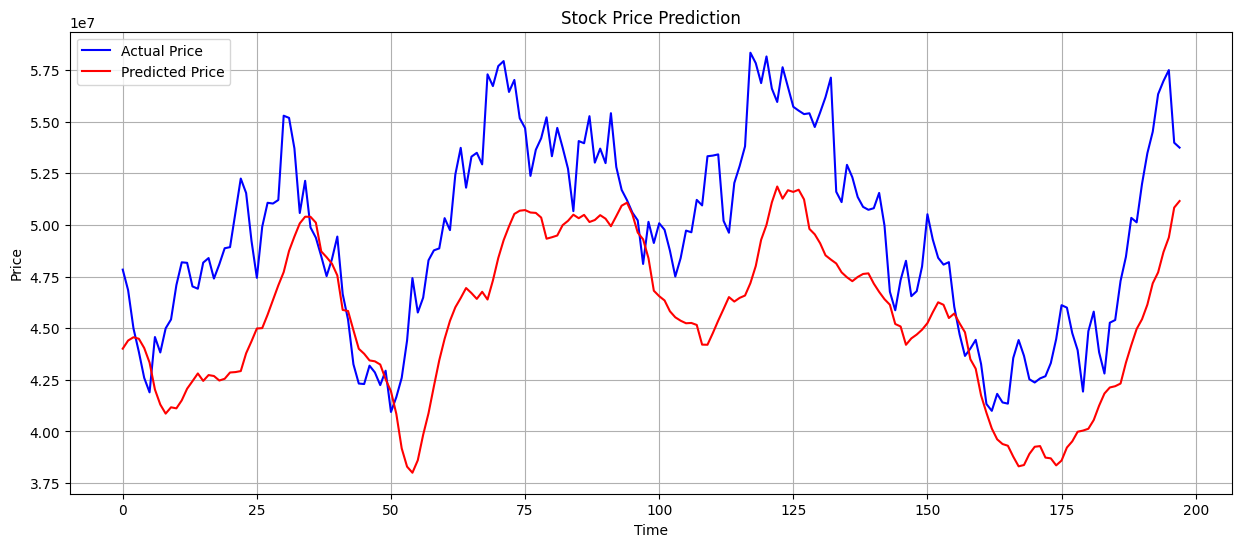


=== 모델 성능 ===
RMSE: 4907779.70
MAE: 4205423.59


In [44]:
# 테스트 데이터로 예측
predictions = model.predict(X_test)

# 예측값을 원래 스케일로 변환
dummy = np.zeros((len(predictions), len(feature_cols)))
dummy[:, stock_data.columns.get_loc(target_col)] = predictions.flatten()
predictions_rescaled = scaler.inverse_transform(dummy)[:, stock_data.columns.get_loc(target_col)]

# 실제값도 원래 스케일로 변환
dummy = np.zeros((len(y_test), len(feature_cols)))
dummy[:, stock_data.columns.get_loc(target_col)] = y_test
actual_rescaled = scaler.inverse_transform(dummy)[:, stock_data.columns.get_loc(target_col)]

# 결과 시각화
plt.figure(figsize=(15, 6))
plt.plot(actual_rescaled, label='Actual Price', color='blue')
plt.plot(predictions_rescaled, label='Predicted Price', color='red')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# 모델 성능 평가
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(actual_rescaled, predictions_rescaled)
rmse = math.sqrt(mse)
mae = mean_absolute_error(actual_rescaled, predictions_rescaled)

print(f'\n=== 모델 성능 ===')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')